In [54]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import cv2
import glob
import re
from matplotlib import pyplot as plt
import time as t
print "OpenCV version: {}".format(cv2.__version__)
# https://wiki.python.org/moin/PythonSpeed/PerformanceTips

OpenCV version: 2.4.11


In [55]:
w = 640
h = 480

crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((8*6,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2) * 3.3

fig_size = plt.rcParams["figure.figsize"]
# print "Current size:", fig_size
fig_size[0] = 18
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

# NOTA: PARAMETRIZAR AJEDREZ, ENTRE OTROS

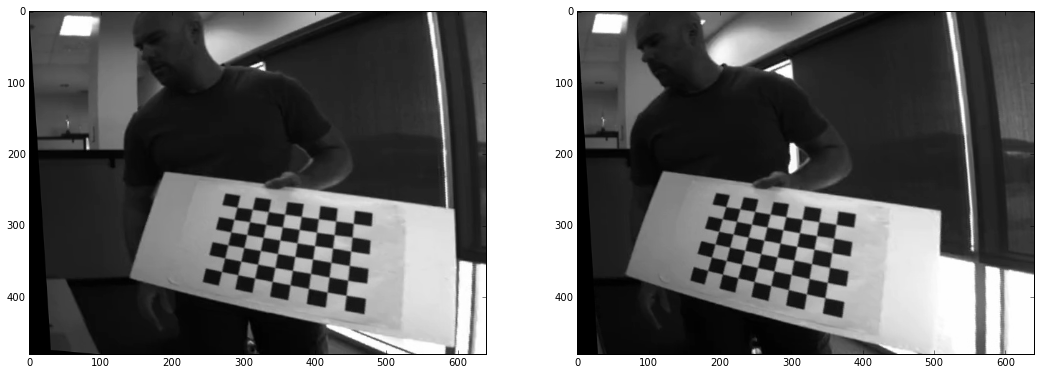

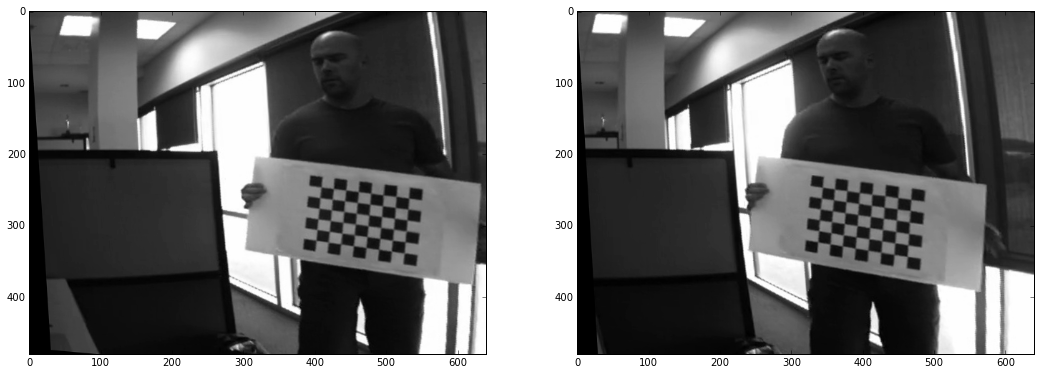

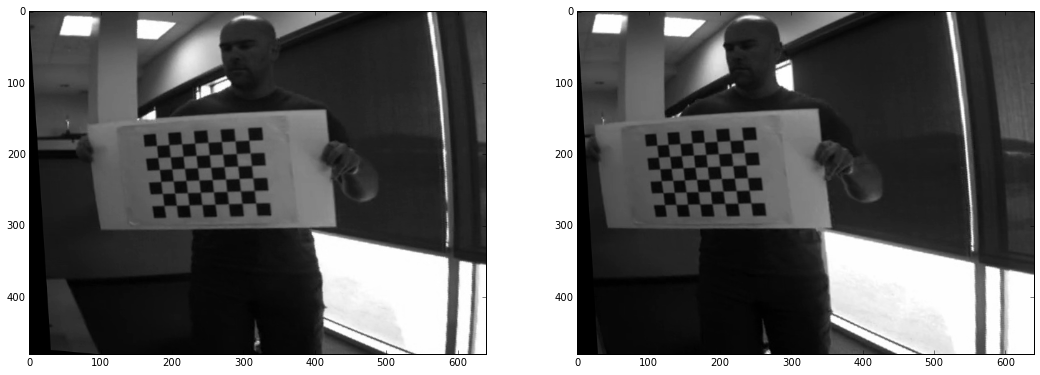

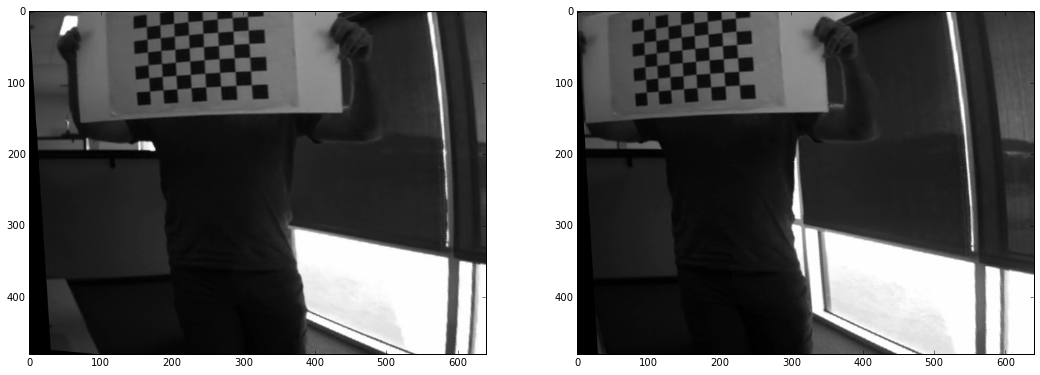

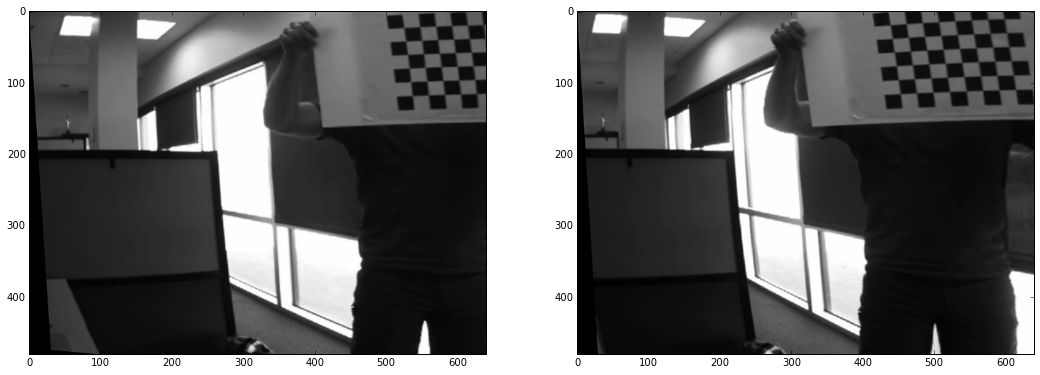

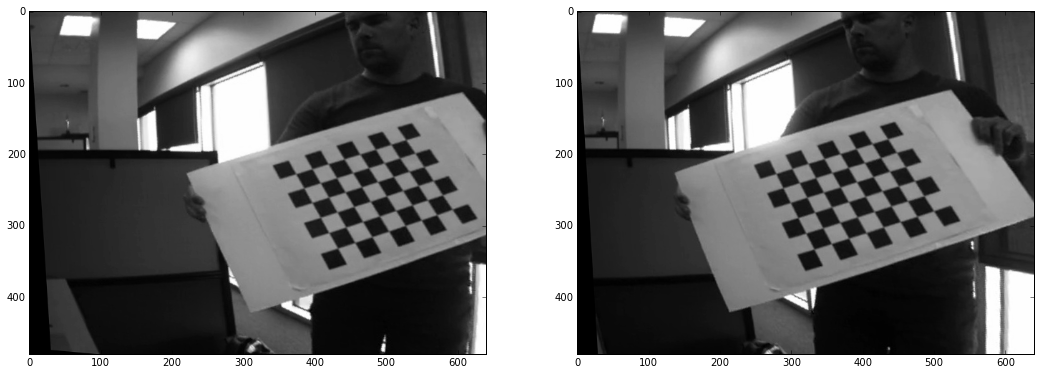

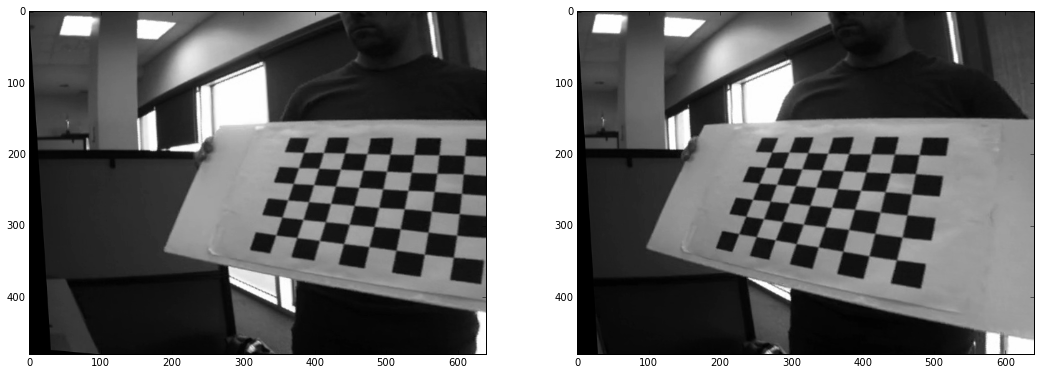

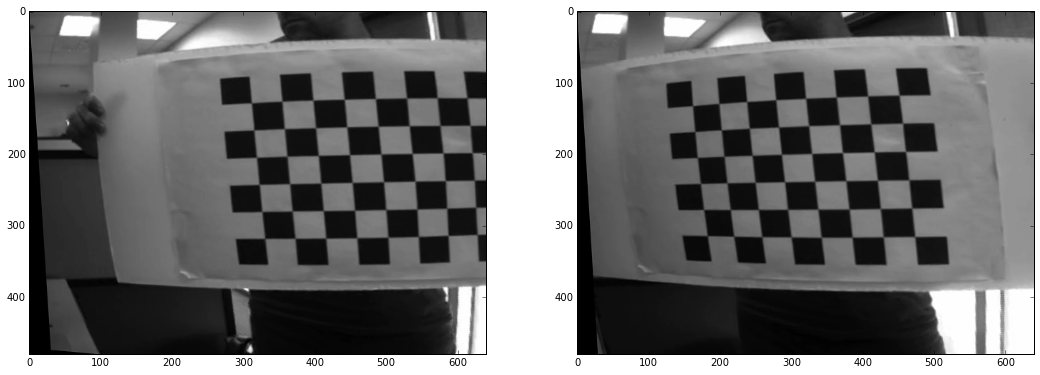

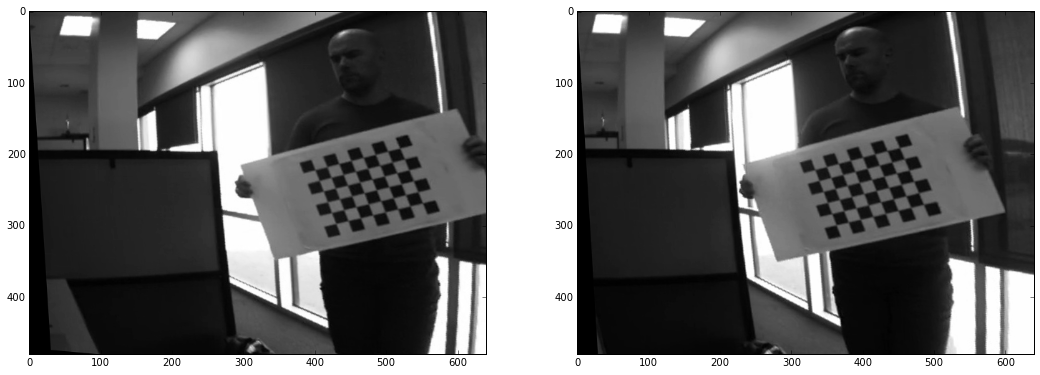

In [73]:
images = glob.glob('stereo-example2/img-calib/*.jpg')
goodImages = []

objpoints = []
imgpoints1 = []
imgpoints2 = []

for fname in images:
    imgR = cv2.imread(fname)
    imgL = imgR[:, 0:640]
    imgR = imgR[:, 640:]
    grayL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)

    retL, cornersL = cv2.findChessboardCorners(grayL, (8,6), None)
    retR, cornersR = cv2.findChessboardCorners(grayR, (8,6), None)
        
    if retL is True and retR is True:
        objpoints.append(objp)
        cv2.cornerSubPix(grayL,cornersL,(11,11),(-1,-1),criteria)
        cv2.cornerSubPix(grayR,cornersR,(11,11),(-1,-1),criteria)
        imgpoints1.append(cornersL)
        imgpoints2.append(cornersR)
        cv2.drawChessboardCorners(imgL, (8,6), cornersL, retL)
        cv2.drawChessboardCorners(imgR, (8,6), cornersR, retR)
        goodImages.append(fname)
        
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints1, (w,h), None, None)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints2, (w,h), None, None)

ret, mtxL, distL, mtxR, distR, R, T, E, F  = cv2.stereoCalibrate(objpoints, imgpoints1, imgpoints2, (640,480))

R1, R2, P1, P2, Q, ROI1, ROI2 = cv2.stereoRectify(mtxL, distL, mtxR, distR, (640,480), R, T,
                                                  flags=cv2.CALIB_ZERO_DISPARITY, alpha=0)

map1L, map2L = cv2.initUndistortRectifyMap(mtxL, distL, R1, mtxL, (640,480), cv2.CV_32FC1)
map1R, map2R = cv2.initUndistortRectifyMap(mtxR, distR, R2, mtxR, (640,480), cv2.CV_32FC1)

for fname in goodImages:
    name = re.findall(r'[\w\d\-]+\.\w+',fname)[0]
    imgR = cv2.imread(fname)
    imgL = imgR[:, 0:640]
    imgR = imgR[:, 640:]    
    dstL = cv2.remap(imgL, map1L, map2L, cv2.INTER_CUBIC)
    dstR = cv2.remap(imgR, map1R, map2R, cv2.INTER_CUBIC)
    dstL = cv2.cvtColor(dstL, cv2.COLOR_BGR2GRAY)
    dstR = cv2.cvtColor(dstR, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('stereo-example2/img-rectified/rectL'+name, dstL)
    cv2.imwrite('stereo-example2/img-rectified/rectR'+name, dstR)
    plt.subplot(1,2,1), plt.imshow(dstL, 'gray')
    plt.subplot(1,2,2), plt.imshow(dstR, 'gray')
    plt.show()

In [72]:
# 274, 256
# 194, 255
print 274 - 194

80


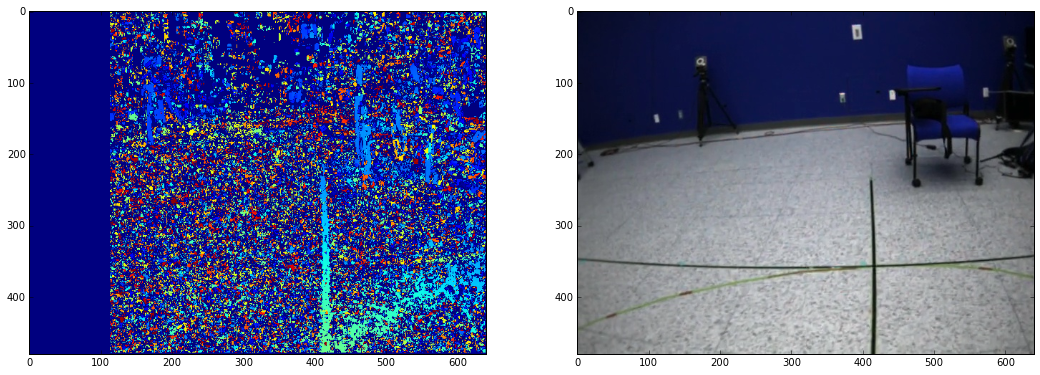

In [80]:
from IPython.html import widgets
from IPython.display import display

path = 'stereo-example2/img-stereo/'

def depthMap(n=0, w=5):
    imgR = cv2.imread(path+'scene00501.jpg')
    imgL = imgR[:, 0:640]
    imgR = imgR[:, 640:]
    # imgL = cv2.remap(imgL, map1L, map2L, cv2.INTER_CUBIC)
    # imgR = cv2.remap(imgR, map1R, map2R, cv2.INTER_CUBIC)
    grayL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
    stereo = cv2.StereoBM(cv2.STEREO_BM_BASIC_PRESET, n, w)
    disparity = stereo.compute(grayL,grayR)
    plt.subplot(2,2,1),plt.imshow(disparity)
    plt.subplot(2,2,3),plt.imshow(imgL)
    plt.show()
    
n_slider = widgets.IntSliderWidget(min=0, max=640, step=16, value=0)
w_slider = widgets.IntSliderWidget(min=5, max=255, step=2, value=5)

w = widgets.interactive(depthMap,n=n_slider,w=w_slider)
display(w)